## Machine Learning
https://www.kaggle.com/datasets/aldinwhyudii/student-depression-and-lifestyle-100k-data

In [11]:
import pandas as pd

dataset = pd.read_csv('student_lifestyle_100k.csv')
dataset['Gender'] = dataset['Gender'].astype('category')
dataset['Department'] = dataset['Department'].astype('category')
dataset['Stress_Level'] = dataset['Stress_Level'].astype('category')

In [12]:
# Aufteilen nach True und False in der Spalte Depression
depressed = dataset[dataset['Depression']]
not_depressed = dataset[~dataset['Depression']]

# 10.000 zufällige negative Stichproben ziehen
not_depressed_sample = not_depressed.sample(n=10062, random_state=42)

# Datensatz zusammensetzen
balanced_dataset = pd.concat([depressed, not_depressed_sample])

data = balanced_dataset.loc[:, 'Age':'Stress_Level']
target = balanced_dataset['Depression']

In [13]:
import torch

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler

# Spaltennamen nach Typ trennen
categorical_cols = data.select_dtypes(include=['category']).columns.tolist()
numeric_cols = data.select_dtypes(include=['number', 'bool']).columns.tolist()

# Preprocessing-Transformer (numerisch: RobustScaler, kategorisch: OneHotEncoder)
preprocessor = ColumnTransformer([
    ("numeric", RobustScaler(), numeric_cols), # RobustScaler() hat keine/kaum Auswirkung
    ("categorical", OneHotEncoder(drop='first'), categorical_cols)
])

data_processed = preprocessor.fit_transform(data)

n = len(data_processed)
input_dim = data_processed.shape[1]
x = torch.tensor(data_processed, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.float32).view(-1, 1)

In [ ]:
from datetime import datetime

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir=f'./data/machine_learning/runs/run_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

ids = torch.randperm(len(x))
train_ids = ids[:int(n * .6)]
val_ids = ids[int(n * .6):int(n * .8)]
test_ids = ids[int(n * .8):]

train_dataset = TensorDataset(x[train_ids], y[train_ids])
val_dataset = TensorDataset(x[val_ids], y[val_ids])
test_dataset = TensorDataset(x[test_ids], y[test_ids])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches per epoch: 378
Validation batches: 126
Test batches: 126


In [15]:
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassificationMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

model = BinaryClassificationMLP(input_dim=input_dim)

# Log the model architecture to TensorBoard
writer.add_graph(model, x[train_ids][:batch_size])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Model Architecture:
BinaryClassificationMLP(
  (fc1): Linear(in_features=19, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Total parameters: 3,393
Trainable parameters: 3,393


In [16]:
criterion = nn.BCEWithLogitsLoss() # nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) # added weight_decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',      # Reduce LR when validation loss stops decreasing
    factor=0.5,      # Multiply LR by 0.5
    patience=10,     # Wait 10 epochs before reducing
)

def train_epoch(model, train_loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()  # Set model to training mode
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y.view_as(predictions)).float()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_X.size(0)
    
    return train_loss / len(train_loader.dataset)  # Return average loss

def validate(model, val_loader, criterion):
    """Validate the model"""
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        for batch_X, batch_y in val_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y.view_as(predictions)).float()
            val_loss += loss.item() * batch_X.size(0)
    
    return val_loss / len(val_loader.dataset)

def compute_metrics(model, data_loader):
    """Compute detailed regression metrics"""
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            logits = model(batch_X)
            preds = (torch.sigmoid(logits) > 0.5).float()
            all_predictions.append(preds)
            all_targets.append(batch_y.view_as(preds))
    
    predictions = torch.cat(all_predictions, dim=0)
    targets = torch.cat(all_targets, dim=0)
    
    accuracy = (predictions == targets).float().mean().item()
    return {
        'accuracy': accuracy,
        'error_rate': 1.0 - accuracy
    }

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 20

for epoch in range(num_epochs):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)

    # Validate
    val_loss = validate(model, val_loader, criterion)
    val_losses.append(val_loss)

    # Log losses to TensorBoard
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalars('Loss/Train_vs_Val', {'Train': train_loss, 'Validation': val_loss}, epoch)

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        torch.save(model.state_dict(), './data/machine_learning/model.pth')  # Save best model
    else:
        patience_counter += 1

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train Loss: {train_loss:7.4f} | "
              f"Val Loss: {val_loss:7.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

writer.close()

Epoch   1/100 | Train Loss:  0.6468 | Val Loss:  0.6389 | LR: 0.001000
Epoch  10/100 | Train Loss:  0.6140 | Val Loss:  0.6334 | LR: 0.001000
Epoch  20/100 | Train Loss:  0.6028 | Val Loss:  0.6329 | LR: 0.000500

Early stopping triggered after 25 epochs



Classification Report:
              precision    recall  f1-score   support

     Class 0       0.66      0.72      0.69      2001
     Class 1       0.70      0.62      0.66      2024

    accuracy                           0.67      4025
   macro avg       0.68      0.67      0.67      4025
weighted avg       0.68      0.67      0.67      4025



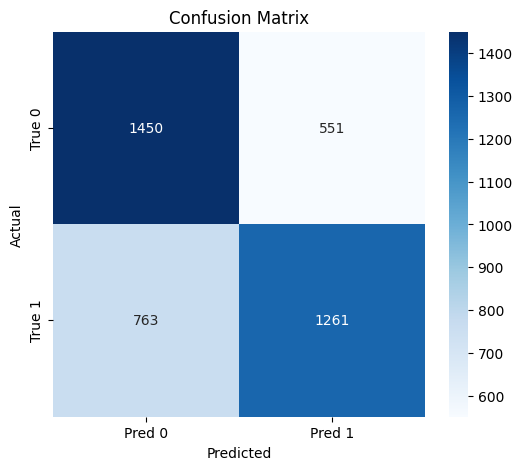

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_classification_results(model, data_loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            logits = model(batch_X)
            # Thresholding logits: > 0 means probability > 0.5
            preds = (logits > 0).float() 
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())

    # 1. Classification Report
    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds, target_names=['Class 0', 'Class 1']))

    # 2. Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Pred 0', 'Pred 1'], 
                yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_classification_results(model, test_loader)